# NeRF Introduction

NeRF is a method that achieves state-of-the-art results for synthesizing novel views of complex scenes by optimizing an underlying continuous volumetric scene function using a sparse set of input views proposed in [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934). NeRF algorithm represents a scene using a fully-connected (non-convolutional) deep network, whose input is a single continuous 5D coordinate (spatial location (x, y, z) and viewing direction ($\theta$, $\phi$)) and whose output is the volume density and view-dependent emitted radiance at that spatial location.


# Goal of this notebook

This notebook implements a simplified NeRF model, which takes 3D coordinate (spatial location (x, y, z)) instead of 5D. It also skips hierarchical sampling procedure and downsizes training images, so that the model is tiny enough to train in Google Colab environment with decent training time. The implementations are based on [NeRF github repo](https://github.com/bmild/nerf) which is implemented in Tensorflow, as well as [Lin's work](https://github.com/yenchenlin/nerf-pytorch/blob/master/run_nerf_helpers.py) which implemented NeRF in Pytorch. Key functions for this notebook are detailedly explained so that it's easy for anyone new to NeRF to follow. 

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. 

Run the following cell to mount Google Drive. Follow the link, sign in to the Google account.

If everything is working correctly then running the following cell should print the filenames from the NeRF repository.

Load several useful packages that are used in this notebook:

In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision


Make sure GPUs are enabled and set device to GPU

In [2]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")
  
DTYPE = torch.float32

Good to go!


#Load NeRF Data

First we download data for two example datasets: `LEGO` and `FERN`, which are provided on [NeRF website](https://www.matthewtancik.com/nerf).

Data loading functions are implemented in data_loader.py, including blender data loader (for `LEGO`) and llff data loader (for `FERN`).

We load `LEGO` data and visualize one sample image below. 

In [3]:
from data_loader import load_blender_data
# LEGO_DIR = os.path.join(GOOGLE_DRIVE_PATH, "data", "nerf_synthetic", "lego")
LEGO_DIR = os.path.join("./data/nerf_synthetic/lego/")
# reduce the image resolution by dev_res, e.g. 800->100 pixels
# note that Google Colab environment provide 16GB GPU RAM, which limits our resolution to about 200*200
dev_res = 4

# load part of the whole dataset 
# no skip for train (100), 100/skip for val, 200/skip for test
skip = 4

images, poses, hwf, i_split = load_blender_data(LEGO_DIR, dev_res, skip, device=DEVICE)
H, W, focal_length = hwf

Images shape:  (175, 200, 200, 4)
Poses shape:  (175, 4, 4)


In [4]:
LEGO_DIR

'./data/nerf_synthetic/lego/'

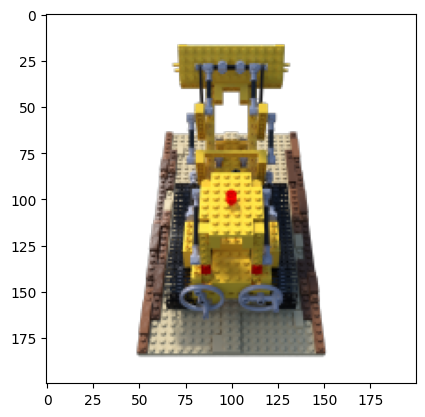

In [5]:
# show the first test image
plt.imshow(images[len(i_split[0])+len(i_split[1])].detach().cpu().numpy())
plt.show()

#Rays Function

#### Get a bundle of rays.

Here we define a function, which takes the height & width of the image, focal length and transformation matrix (camera pose) as input. The function outputs a set of origin points and direction vectors, which could be used to describe rays shooting out from image pixels.

In [6]:
from NeRF import get_rays
ray_origins, ray_directions = get_rays(H, W, focal_length, poses[1])
print(ray_origins.shape, ray_directions.shape)
print(ray_origins.device, ray_origins.dtype)

torch.Size([200, 200, 3]) torch.Size([200, 200, 3])
cuda:0 torch.float32


In [7]:
print(ray_directions[0][0])

tensor([ 0.7241, -0.8570,  0.0214], device='cuda:0')


#### Sample a set of 3D points given the bundle of rays.

During volumn rendering, the original paper states that the color observed by the camera could be calculated by volume rendering equation, which get the integral along the rays. In order to speed up the calculation, we approximate integrals with a set of sampled 3D points on the rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. Then we sample 3D points along each ray.

In [8]:
num_samples = 4
near_point = 2
far_point = 6

In [9]:
from NeRF import sample_points_from_rays
sampled_points, depth_values = sample_points_from_rays(
                                 ray_origins,
                                 ray_directions,
                                 near_point=near_point,
                                 far_point=far_point,
                                 num_samples=num_samples,
                                 random=True
                               )
print(depth_values.shape)
print(sampled_points.shape)
print(sampled_points[0][0])

torch.Size([200, 200, 4])
torch.Size([200, 200, 4, 3])
tensor([[ 0.7507,  1.0105,  1.3523],
        [ 1.2964,  0.3646,  1.3684],
        [ 1.9976, -0.4652,  1.3891],
        [ 3.1500, -1.8291,  1.4232]], device='cuda:0')


# Positional Encoding

Deep networks are biased towards learning lower frequency functions, thus it performs poorly at representing high-frequency variation in color and geometry. Recent work shows that mapping the inputs to a higher dimensional space using high frequency functions before passing them to the network enables better fitting of data that contains high frequency variation.

Therefore, we use positional encoding to map continuous input coordinates into a higher dimensional space to enable our MLP to more easily approximate a higher frequency function.

The encoding function used by original paper (section 5.1), which map each sampled point on the rays from $\mathbb{R}^3$ to a higher dimensional space $\mathbb{R}^{2L}$ or $\mathbb{R}^{2L+1}$ (we might include input in positional encoding):
$$γ(p) = (sin(2^0 π p), cos(2^0 π p), ..., sin(2^{L-1} π p), cos(2^{L-1} π p))$$



In [10]:
from NeRF import positional_encoding
flattened_sampled_points = sampled_points.reshape((-1, 3))
pos_out = positional_encoding(flattened_sampled_points, 3)

# Tiny NeRF Model

Initialize a tiny nerf network, which composed of linear layers and ReLU activation. We keep it simple for now so that we could train that on Google Colab.

Note that the model takes 3D input (encoded xyz coordinates), which is different from the 5D input used in original paper (which includes view directions, in addition to xyz coordinates)

In [11]:
from NeRF import TinyNeRF
pos_dim = pos_out.shape[-1]
model = TinyNeRF(pos_dim, fc_dim=128)
model.cuda()

TinyNeRF(
  (nerf): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

#Volumn Rendering

We feed the x,y,z coordinate to out tiny NeRF model, which consists of fully connected layer. The model forward returns predicted RGB color and predicted volume density for each sampled point on the rays.

In [12]:
radiance_field = model(pos_out)
radiance_field = radiance_field.view(H, W, num_samples, 4)

In [13]:
print(radiance_field[0][0])

tensor([[ 0.0126,  0.0325, -0.0160,  0.0604],
        [ 0.0103,  0.0473, -0.0188,  0.0608],
        [-0.0042,  0.0361, -0.0502,  0.0492],
        [ 0.0541,  0.0531, -0.0677,  0.0484]], device='cuda:0',
       grad_fn=<SelectBackward0>)


Color observed by the camera could be calculated by volume rendering equation:
$$C(r) = \int_{t_{near}}^{t_{far}} T(t) \sigma (r(t))c(r(t), d),\mathrm{d}t$$

$$T(t) = exp(- \int_{t_{near}}^t \sigma (r(s)), \mathrm{d}s)$$

We approximate integrals with a set of samples:
$$\alpha_i = 1-exp(-\sigma_i \delta_i)$$
$$C(r) = \sum_{i=1}^{N} T_i \alpha_i c_i$$
$$T_i = exp(-\sum_{j=1}^{i-1} \sigma_i \delta_i) = 
\prod_{j=1}^{i-1} exp(-\sigma_i \delta_i) = \prod_{j=1}^{i-1} 1 - \alpha_i$$

In [14]:
from NeRF import volume_rendering
rgb_map, depth_map, acc_map = volume_rendering(radiance_field, ray_origins, depth_values)

# Training Time!

Now we have implemented all the components for a TinyNeRF model, the only thing left is to combine them for training.

To perform one iteration of training, we implemented a function called `tinynerf_step_forward` in NeRF.py, which
- Get a bundle of rays going through all image pixels
- Sample query points along each ray
- Feed the model with chunks of encoded points to avoid out-of-memory issue (referring to [tiny_nerf_pytorch](https://colab.research.google.com/drive/1rO8xo0TemN67d4mTpakrKrLp03b9bgCX#scrollTo=XZh3aklt3ZET))
- Perform differentiable volume rendering to re-synthesize the RGB image

Besides, we also implemented a `train` function, which perform complete training process of the model. It takes in multiple arguments which you can define below. The `train` function will visualize the rendered first test image and PSNR every 100 training iterations.

loss: tensor(0.1751, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss: 0.17105209827423096


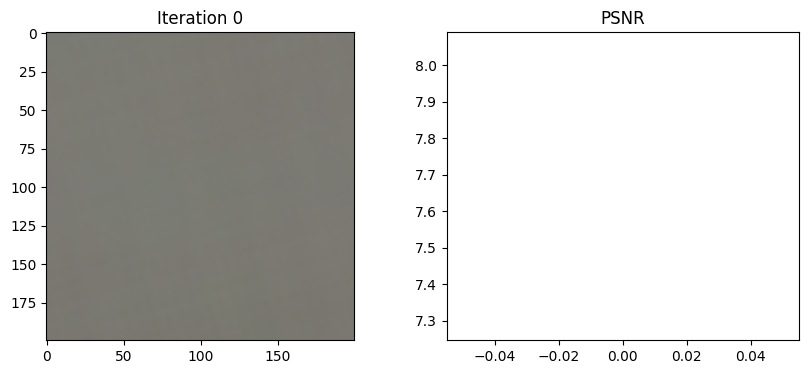

loss: tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss: 0.02208610810339451


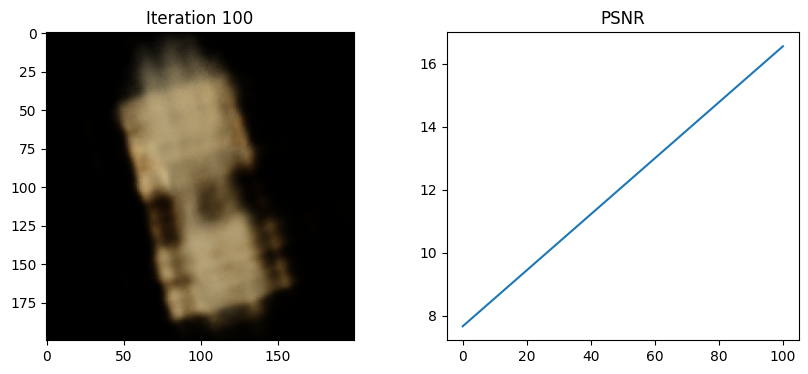

loss: tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss: 0.013030084781348705


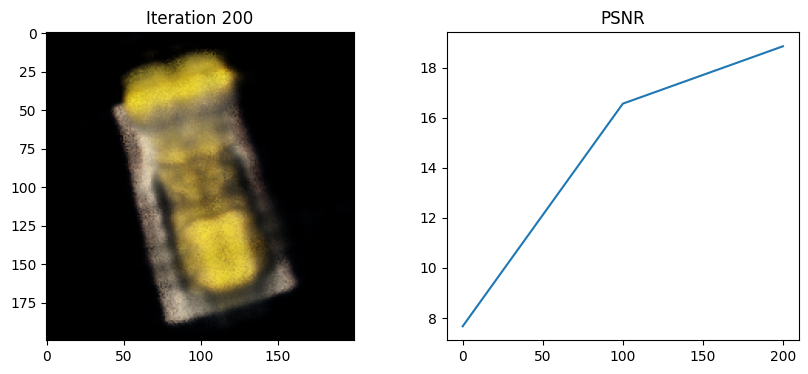

loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss: 0.012090022675693035


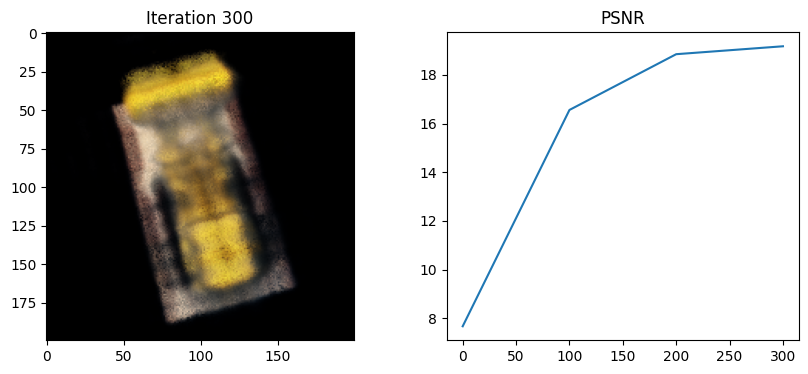

loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss: 0.011829599738121033


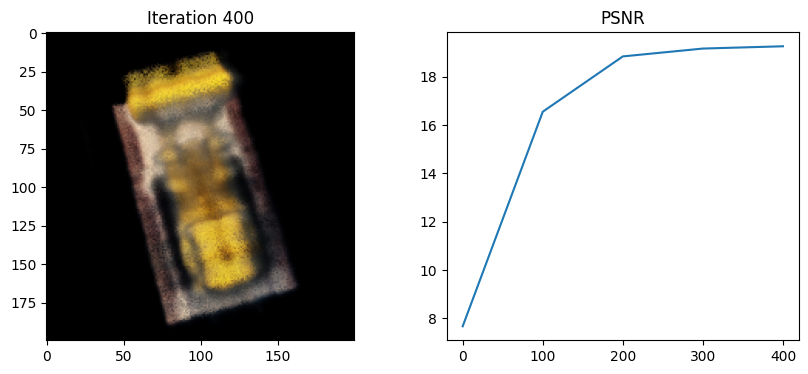

loss: tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)
loss: tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


In [ ]:
from NeRF import train
from NeRF import tinynerf_step_forward

# Near and far clipping distance
near_point = 2
far_point = 6

# Encoder definition, we use positional encoding
freq = 6
include_input = True
encoder = lambda x: positional_encoding(x, include_input=include_input, freq=freq)
enc_dim = (include_input + 2 *freq) * 3

# Define a tinynerf model, feel free to change the `fc_dim`
model = TinyNeRF(enc_dim, fc_dim=128)
model.cuda()

# Number of depth samples along each ray.
num_depth_samples_per_ray = 64

num_iters = 2000
train(images, poses, hwf, i_split, near_point,
      far_point, num_depth_samples_per_ray, encoder, 
      num_iters, model)

# Render 360 Video

In [21]:
import numpy as np
from NeRF import tinynerf_step_forward
from NeRF import get_minibatches
from tqdm import tqdm_notebook as tqdm

trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    tmp = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).to(dtype=torch.float32)
    c2w = tmp @ c2w
    return c2w

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.).to(device="cuda")
    rays_o, rays_d = get_rays(H, W, focal_length, c2w[:3,:4])
    rgb = tinynerf_step_forward(H, W, focal_length,
                                            c2w, 2, 6, 64, encoder,
                                            get_minibatches, model)
    rgb = rgb.detach().cpu().numpy()
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/120 [00:00<?, ?it/s]

In [22]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)